<a href="https://colab.research.google.com/github/pinakm9/sphere-fp/blob/master/data/10D/sphere10D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [ ]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'sphere-fp'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/sphere-fp.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'sphere-fp'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 255 (delta 46), reused 99 (delta 31), pack-reused 121
Receiving objects: 100% (255/255), 58.27 MiB | 27.26 MiB/s, done.
Resolving deltas: 100% (80/80), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [ ]:
DTYPE = 'float32'
D = 1.0
dim = 10
ones = np.ones(dim)
domain = [-2. * ones, 2. * ones]
save_folder = '{}/data/{}D'.format(repo, dim)

@tf.function
def diff_log_op(f, x, y, x1, y1, x2, y2, x3, y3, x4, y4):
    z = 4.*(x**2 + y**2 - 1.) 
    z1 = 4.*(x1**2 + y1**2 - 1.)
    z2 = 4.*(x2**2 + y2**2 - 1.)
    z3 = 4.*(x3**2 + y3**2 - 1.)
    z4 = 4.*(x4**2 + y4**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, x1, y1, x2, y2, x3, y3, x4, y4])
        f_ = f(x, y, x1, y1, x2, y2, x3, y3, x4, y4)
        f_x, f_y, f_x1, f_y1, f_x2, f_y2, f_x3, f_y3, f_x4, f_y4 = tape.gradient(f_, [x, y, x1, y1, x2, y2, x3, y3, x4, y4])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_x1x1 = tape.gradient(f_x1, x1)
    f_y1y1 = tape.gradient(f_y1, y1)
    f_x2x2 = tape.gradient(f_x2, x2)
    f_y2y2 = tape.gradient(f_y2, y2)
    f_x3x3 = tape.gradient(f_x3, x3)
    f_y3y3 = tape.gradient(f_y3, y3)
    f_x4x4 = tape.gradient(f_x4, x4)
    f_y4y4 = tape.gradient(f_y4, y4)
    return z*(x*f_x + y*f_y) + z1*(x1*f_x1 + y1*f_y1) + z2*(x2*f_x2 + y2*f_y2) + z3*(x3*f_x3 + y3*f_y3) + z4*(x4*f_x4 + y4*f_y4) + 4.*(z+ z1 + z2 + z3 + z4 + dim) \
           + D*(f_x**2 + f_y**2 + f_xx + f_yy + f_x1**2 + f_y1**2 + f_x1x1 + f_y1y1 + f_x2**2 + f_y2**2 + f_x2x2 + f_y2y2 + f_x3**2 + f_y3**2 + f_x3x3 + f_y3y3 + f_x4**2 + f_y4**2 + f_x4x4 + f_y4y4) 

**Define the steady state $p_\infty(\mathbf x)$**

In [ ]:
from scipy.special import erf
import numpy as np

def p_inf2(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z 

def p_inf(x, y, x1, y1, x2, y2, x3, y3, x4, y4):
  return p_inf2(x, y) * p_inf2(x1, y1) * p_inf2(x2, y2) * p_inf2(x3, y3) * p_inf2(x4, y4)

# X0 = np.random.uniform(size=(10, dim)).astype(DTYPE)
# x, y, x1, y1, x2, y2, x3, y3 = np.split(X0, dim, axis=-1)
# diff_log_op(lambda *args: tf.math.log(p_inf(*args)), x, y, x1, y1, x2, y2, x3, y3)

**Set up experiment parameters and learn the stationary distribution**

In [ ]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
model_path = None#'{}/sphere{}D'.format(save_folder, dim)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='sphere{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain, model_path=model_path)
solver.learn(epochs = 1300000, n_sample = 1000, save_folder=save_folder)

Streaming output truncated to the last 5000 lines.
1250000    0.032140        59033.7708
1250010    0.031937        59034.2403
1250020    0.029695        59034.7083
1250030    0.031365        59035.1794
1250040    0.029835        59035.6668
1250050    0.028013        59036.1419
1250060    0.032256        59036.6204
1250070    0.035498        59037.1074
1250080    0.032003        59037.6007
1250090    0.028966        59038.0613
1250100    0.031854        59038.5395
1250110    0.036849        59039.0076
1250120    0.031816        59039.4737
1250130    0.035623        59039.9399
1250140    0.030764        59040.3936
1250150    0.029500        59040.8644
1250160    0.034592        59041.3203
1250170    0.035370        59041.7985
1250180    0.029372        59042.2617
1250190    0.026529        59042.7634
1250200    0.031697        59043.2432
1250210    0.028161        59043.7309
1250220    0.035518        59044.1946
1250230    0.031572        59044.6885
1250240    0.035737        59045.1793

**Visualize the learned distribution**

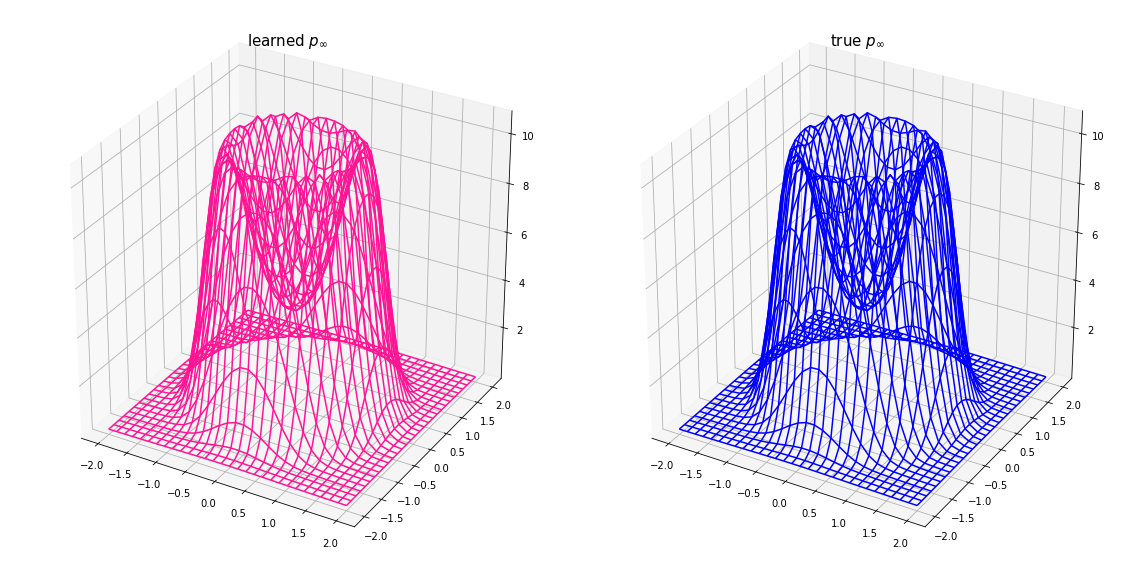

In [ ]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=domain[0], high=domain[1]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  
def learned(x, y):
  z = tf.zeros_like(x)
  zs = [z] * (dim - 2)
  return tf.exp(solver.net(x, y, *zs))


plot_solutions(learned=learned, true=learned)

**Investigate the size of $θ$**

In [ ]:
solver.net.summary()

Model: "sphere10D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMForgetBlock (LSTMForget  multiple                 4200      
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 12200     
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 12200     
 Block)                                                          
                                                                 
 dense (Dense)               multiple                  51        
                                                                 
 batch_normalization (BatchN  multiple                 0 (unused)
 ormalization)                                           